In [1]:
!nvidia-smi
from google.colab import drive
drive.mount('/content/drive')
!ls drive/'My Drive'/'Colab Notebooks'/
!pip install -r drive/'My Drive'/'Colab Notebooks'/JJI_Project/requirements.txt
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'
import sys
sys.path.append('drive/My Drive/Colab Notebooks/')

Sun Feb  6 08:02:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from tqdm import tqdm

from JJI_Project.dataloader.dataloader import BERTDataset
from JJI_Project.model.kobert_model import BERTClassifier

In [7]:
ctx = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(ctx)

root_path='drive/My Drive/Colab Notebooks/JJI_Project'


dataset_train = []
file = open(f'{root_path}/input/test.txt', 'r', encoding='utf-8')
while True:
    line = file.readline()
    if not line:
        break
    dataset_train.append([line[:-3], line[-2]])
file.close()
print(len(dataset_train))


max_len = 64
batch_size = 8
warmup_ratio = 0.1
num_epochs = 30
max_grad_norm = 1
learning_rate = 5e-5
add_token = ['ㄱ', 'ㄴ', 'ㄷ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅅ', 'ㅇ', 'ㅈ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ',
             'ㄲ', 'ㄸ', 'ㅃ', 'ㅆ', 'ㅉ', 'ㄳ', 'ㄵ', 'ㄶ', 'ㄺ', 'ㄻ', 'ㄼ', 'ㄽ', 'ㄾ', 'ㄿ', 'ㅀ', 'ㅄ']


train_dataset = BERTDataset(dataset_train, add_token=add_token)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
model = BERTClassifier(vocab_size=train_dataset.vocab_size, add_token=train_dataset.added_token_num)
model.to(device)


no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()


t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

5825


In [10]:
checkpoint_path =f"{root_path}/output"
save_ckpt_path = f'{checkpoint_path}/model/cp_badword.pt'

pre_epoch, pre_loss, train_step = 0, 0, 0
if os.path.isfile(save_ckpt_path):
    checkpoint = torch.load(save_ckpt_path, map_location=device)
    
    pre_epoch = checkpoint['Epoch']
    model.load_state_dict(checkpoint['State_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

    # pre_loss = checkpoint['Loss']
    # train_step =  checkpoint['Train_no']
    # total_train_step =  checkpoint['Total_train_step']

    print(f"load pretrain from: {save_ckpt_path}, epoch={pre_epoch}")  #, loss={pre_loss}\n")
    # best_epoch += 1

load pretrain from: drive/My Drive/Colab Notebooks/JJI_Project/output/model/cp_badword.pt, epoch=0


In [11]:
for epoch in range(num_epochs):
    model.train()
    for batch_id, (input_ids, token_type_ids, attention_mask, label) in enumerate(tqdm(train_dataloader)):
        input_ids = input_ids.long().to(device)
        token_type_ids = token_type_ids.long().to(device)
        attention_mask = attention_mask.long().to(device)
        label = label.long().to(device)

        optimizer.zero_grad()
        out = model(input_ids, token_type_ids, attention_mask)
        loss = loss_fn(out, label)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
    state = {'Epoch': epoch,
             'State_dict': model.state_dict(),
             'optimizer': optimizer.state_dict()}
    torch.save(state, f'{checkpoint_path}/model/cp_badword.pt')

model.eval()
torch.save(model, f'{checkpoint_path}/model/badword.pt')

100%|██████████| 729/729 [02:02<00:00,  5.94it/s]


In [ ]:
### 코드 참조

# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd
# from IPython.display import display
# from tqdm import tqdm

# import torch
# from transformers import AdamW
# from torch.utils.data import dataloader
# from final_project.dataloader.wellness import WellnessTextClassificationDataset
# from final_project.model.kobert import KoBERTforSequenceClassfication

Downloading:   0%|          | 0.00/371k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/369M [00:00<?, ?B/s]

load pretrain from: drive/My Drive/Colab Notebooks/final_project/checkpoint/test_KOBERT.pth, epoch=0


Train(9): 100%|██████████| 12/12 [00:12<00:00,  1.01s/it, Loss: 0.434 (1.098)]


,loss
0,3.489391
1,2.145662
2,1.744147
3,1.630940
4,1.545331
5,1.375264
6,1.345658
7,1.184567
8,1.231943
9,1.098433


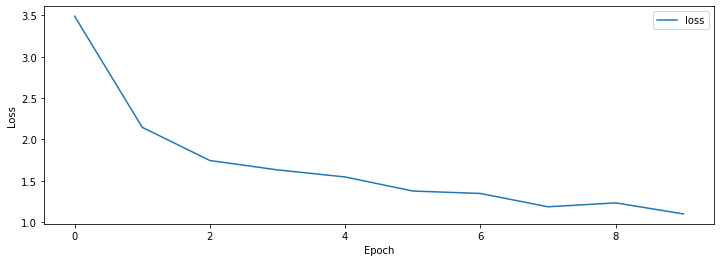

In [ ]:
# root_path='drive/My Drive/Colab Notebooks/final_project'
# data_path = f"{root_path}/data/test_KOBERT.txt"
# checkpoint_path =f"{root_path}/checkpoint"
# save_ckpt_path = f"{checkpoint_path}/test_KOBERT.pth"

# n_epoch = 10          # Num of Epoch
# batch_size = 8      # 배치 사이즈
# ctx = "cuda" if torch.cuda.is_available() else "cpu"
# device = torch.device(ctx)
# save_step = 100 # 학습 저장 주기
# learning_rate = 5e-6  # Learning Rate

# # WellnessTextClassificationDataset 데이터 로더
# dataset = WellnessTextClassificationDataset(file_path=data_path, device=device)
# train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# model = KoBERTforSequenceClassfication()
# model.to(device)

# # Prepare optimizer and schedule (linear warmup and decay)
# no_decay = ['bias', 'LayerNorm.weight']
# optimizer_grouped_parameters = [
#     {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
#       'weight_decay': 0.01},
#     {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
# ]
# optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

# pre_epoch, pre_loss, train_step = 0, 0, 0
# if os.path.isfile(save_ckpt_path):
#     checkpoint = torch.load(save_ckpt_path, map_location=device)
#     pre_epoch = checkpoint['epoch']
#     # pre_loss = checkpoint['loss']
#     train_step =  checkpoint['train_step']
#     total_train_step =  checkpoint['total_train_step']

#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#     print(f"load pretrain from: {save_ckpt_path}, epoch={pre_epoch}")  #, loss={pre_loss}\n")
#     # best_epoch += 1

# losses = []
# offset = pre_epoch
# for step in range(n_epoch):
#     epoch = step + offset
#     loss = train(device, epoch, model, optimizer, train_loader, save_step, save_ckpt_path, train_step)
#     losses.append(loss)

# # data
# data = {
#     "loss": losses
# }
# df = pd.DataFrame(data)
# display(df)

# # graph
# plt.figure(figsize=[12, 4])
# plt.plot(losses, label="loss")
# plt.legend()
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()